# Линейная регрессия.

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sklearn
import sklearn.linear_model
import sklearn.metrics

In [3]:
data = pd.read_csv('wine_regression.csv')

In [4]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,8.30525,0.525613,0.271950,2.522500,0.087540,16.267500,47.020000,0.996712,3.303900,0.648200,10.381125,5.602500
std,1.73299,0.181845,0.193609,1.333098,0.046727,10.934342,35.198465,0.001889,0.147992,0.157134,1.032203,0.846336
min,5.00000,0.120000,0.000000,1.200000,0.039000,1.000000,6.000000,0.990800,2.920000,0.400000,8.800000,3.000000
25%,7.10000,0.390000,0.090000,1.900000,0.070000,7.000000,21.000000,0.995648,3.200000,0.550000,9.500000,5.000000
50%,7.90000,0.520000,0.260000,2.200000,0.078000,14.000000,37.000000,0.996750,3.300000,0.610000,10.050000,6.000000
75%,9.20000,0.631250,0.420000,2.600000,0.091000,23.000000,61.000000,0.997873,3.390000,0.710000,11.000000,6.000000
max,15.50000,1.185000,0.760000,13.800000,0.415000,68.000000,289.000000,1.003150,4.010000,1.590000,14.000000,8.000000


Данные часть набора данных о химическом составе испанских и португальских вин - кислотность, количество сахара, плотность, количество диоксида серы, количество спирта. Последний столбец - quality - результат слепого тестирования вин - оценка от 0 до 10.
В этом ноутбуке надо построить регрессию от параметров данных на стобец quality.

**Построить регресию на качество**   
Здесь достаточно данных, можно попробовать поработать над качеством модели.

In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

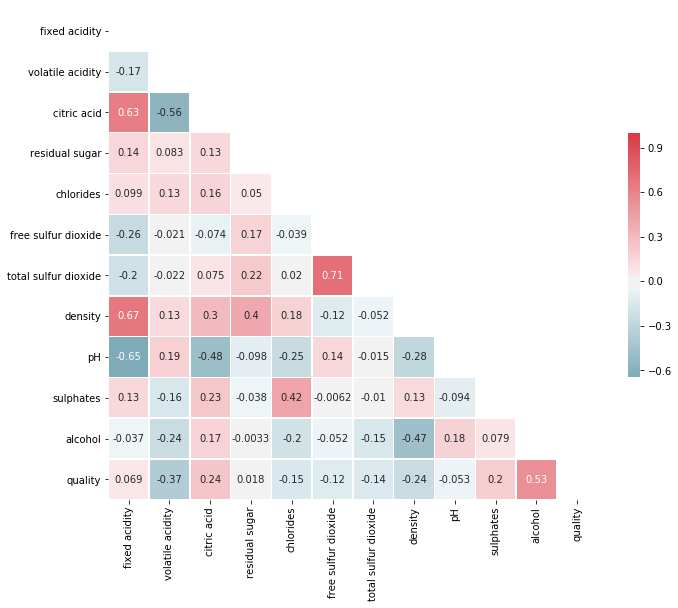

In [6]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Данный сильно скореллированы, но не настолько, чтобы выкидывать что-то. В дальнейшем проверим PCA

In [7]:
data.groupby('quality').mean()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,7.425000,0.986250,0.022500,2.887500,0.080000,9.250000,21.500000,0.997143,3.492500,0.552500,10.337500
4,8.321053,0.692105,0.145263,2.373684,0.079842,16.473684,38.526316,0.996947,3.359474,0.621579,10.078947
5,8.279042,0.552275,0.260000,2.560479,0.099012,18.035928,56.766467,0.997248,3.288862,0.632096,9.799401
6,8.183544,0.502247,0.270633,2.394937,0.080620,15.756329,41.955696,0.996362,3.313481,0.640759,10.600211
7,8.902174,0.415326,0.387391,2.898913,0.076478,12.467391,36.760870,0.996064,3.285870,0.729130,11.677536
8,8.200000,0.410000,0.321667,2.166667,0.064667,13.666667,31.666667,0.994955,3.306667,0.820000,11.850000


In [8]:
data.groupby('quality').std()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,,,,,,,,,,,
3,0.660177,0.174994,0.020616,1.143369,0.014944,7.182154,18.375709,0.001261,0.136229,0.057951,0.612883
4,1.753276,0.208589,0.167477,0.910947,0.021230,11.558395,30.216567,0.001421,0.155044,0.195938,0.661294
5,1.542406,0.151985,0.184932,1.505840,0.065567,12.252805,36.949159,0.001532,0.137938,0.177108,0.584797
6,1.764796,0.178416,0.184687,1.145904,0.023551,9.604063,29.069945,0.001952,0.153701,0.126025,0.963276
7,2.208317,0.164149,0.209140,1.456918,0.021752,8.628378,42.946574,0.002411,0.148841,0.127276,1.033132
8,1.805547,0.104115,0.220764,0.467618,0.011961,13.603921,29.783664,0.002287,0.153449,0.167690,1.380942


Опять выкинем плотность. Видно, что citric acid, pH, что очевидно после кислоты, количество сульфатов как-то прямо влияют на качество

In [9]:
data.drop('density',axis=1,  inplace=True)

Text(0.5, 1.0, 'distribution of wine quality')

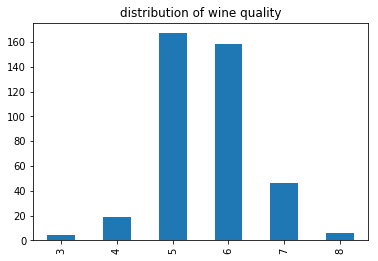

In [10]:
data.quality.value_counts().sort_index().plot.bar()
plt.title('distribution of wine quality')

Распределение количеств вин по качеству сдвинуто от равномерного состояния в нормальное

In [11]:
X, y = data.drop('quality', axis=1), data.quality

Голые регрессоры без подкручивания:

In [12]:
def simple_regsrs(X, y, scale=True, pca=False):
    if pca:
        X = PCA().fit_transform(X)
    scale = False
    if scale:
        X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    regressors = [KNeighborsRegressor(3), 
                  LinearRegression(), 
                  ExtraTreesRegressor(100, criterion='mae',), 
                  LGBMRegressor(n_estimators=50), 
                  CatBoostRegressor(2000, 
                        loss_function='MAE', 
                        logging_level='Silent', 
                        random_state=32, 
                        early_stopping_rounds=300,), ]
    reg_name = 'KNeighborsRegressor LinearRegression ExtraTreesRegressor LGBMRegressor CatBoostRegressor'.split()
    predictions = []
    for R,n in zip(regressors, reg_name):
        R.fit(X_train, y_train)
        print(n)
        y_pred = R.predict(X_test)
        predictions.append(y_pred)
        print(mean_absolute_error(y_test, y_pred))
        print('-'*20)
    return np.array(predictions), y_test

In [13]:
prds, y_test = simple_regsrs(X,y)

KNeighborsRegressor
0.6624999999999999
--------------------
LinearRegression
0.5063038766553899
--------------------
ExtraTreesRegressor
0.402375
--------------------
LGBMRegressor
0.4713289238088968
--------------------
CatBoostRegressor
0.44906917693383586
--------------------


Все работают +- неплохо. Попробуем их объединить

In [38]:
mean_absolute_error(y_test, np.sum(prds, axis=0) / 5)

0.44759178376558406

Возьмем древесные формы

In [39]:
mean_absolute_error(y_test, np.sum(prds[2:], axis=0) / 3)

0.42243034406526603

Проанализируем эффективность принципиальных компонент

In [40]:
pca_prds, y_test = simple_regsrs(X, y, pca=True)

KNeighborsRegressor
0.6624999999999999
--------------------
LinearRegression
0.506303876655393
--------------------
ExtraTreesRegressor
0.4069375
--------------------
LGBMRegressor
0.4940754427212992
--------------------
CatBoostRegressor
0.4471337533471056
--------------------


PCA не нужен

А теперь попробуем улучшить ExtraTreesRegressor, который дает лучший скор

In [41]:
regsr = ExtraTreesRegressor(criterion='mae', n_jobs=4)

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None, 20, 40 ,100]
n_estimators = [50, 100, 200]

params = {'min_samples_leaf' : min_samples_leaf, 
          'max_features' : max_features, 
          'max_depth' : max_depth, 
          'n_estimators': n_estimators}

grid_forest = GridSearchCV(regsr, params, scoring='neg_mean_absolute_error', n_jobs=4, cv=5, verbose=1,)

In [22]:
grid_forest.fit(X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   43.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=4,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'min_samples_leaf': [1, 2, 3], 'max_features': [0.3, 0.5, 0.7], 'max_depth': [None, 20, 40, 100], 'n_estimators': [50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=1)

In [23]:
-grid_forest.best_score_, grid_forest.best_params_

(0.43,
 {'max_depth': None,
  'max_features': 0.3,
  'min_samples_leaf': 1,
  'n_estimators': 50})

Скор не поднялся, но утвердился. На новых данных, не сильно отличных от имеющихся, скор будет примерно такой же - _**0.43**_. Т.е. качество будет предсказываться с такой ошибкой